In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [2]:

class StyleTransferAutoencoder(nn.Module):
    def __init__(self):
        super(StyleTransferAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # 640x360
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 320x180
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 160x90
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 320x180
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 640x360
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), # 1280x720
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
transform = transforms.Compose([
    transforms.Resize((720, 1280)),
    transforms.ToTensor(),
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:

# Load your datasets
initial_images_dataset = datasets.ImageFolder(root='../../Dataset/AbstractArt/Captures', transform=transform)
desired_images_dataset = datasets.ImageFolder(root='../../Dataset/AbstractArt/Renders', transform=transform)

assert len(initial_images_dataset) == len(desired_images_dataset), "Datasets must be of the same size"
initial_images_loader = DataLoader(initial_images_dataset, batch_size=4, shuffle=False)
desired_images_loader = DataLoader(desired_images_dataset, batch_size=4, shuffle=False)

In [14]:
model = StyleTransferAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0
    for (initial_data, _), (desired_data, _) in zip(initial_images_loader, desired_images_loader):
        initial_images = initial_data.to(device)
        desired_images = desired_data.to(device)
        
        optimizer.zero_grad()
        output_images = model(initial_images)
        loss = criterion(output_images, desired_images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(initial_images_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

torch.save(model.state_dict(), 'style_transfer_autoencoder.pth')

Epoch [1/50], Loss: 0.0241
Epoch [2/50], Loss: 0.0208
Epoch [3/50], Loss: 0.0194
Epoch [4/50], Loss: 0.0185
Epoch [5/50], Loss: 0.0181
Epoch [6/50], Loss: 0.0177
Epoch [7/50], Loss: 0.0174
Epoch [8/50], Loss: 0.0173
Epoch [9/50], Loss: 0.0168
Epoch [10/50], Loss: 0.0166
Epoch [11/50], Loss: 0.0162
Epoch [12/50], Loss: 0.0166
Epoch [13/50], Loss: 0.0160
Epoch [14/50], Loss: 0.0152
Epoch [15/50], Loss: 0.0162
Epoch [16/50], Loss: 0.0170
Epoch [17/50], Loss: 0.0158
Epoch [18/50], Loss: 0.0169
Epoch [19/50], Loss: 0.0174
Epoch [20/50], Loss: 0.0158
Epoch [21/50], Loss: 0.0153
Epoch [22/50], Loss: 0.0148
Epoch [23/50], Loss: 0.0148
Epoch [24/50], Loss: 0.0147
Epoch [25/50], Loss: 0.0151
Epoch [26/50], Loss: 0.0140
Epoch [27/50], Loss: 0.0136
Epoch [28/50], Loss: 0.0129
Epoch [29/50], Loss: 0.0126
Epoch [30/50], Loss: 0.0122
Epoch [31/50], Loss: 0.0120
Epoch [32/50], Loss: 0.0118
Epoch [33/50], Loss: 0.0117
Epoch [34/50], Loss: 0.0115
Epoch [35/50], Loss: 0.0115
Epoch [36/50], Loss: 0.0114
E

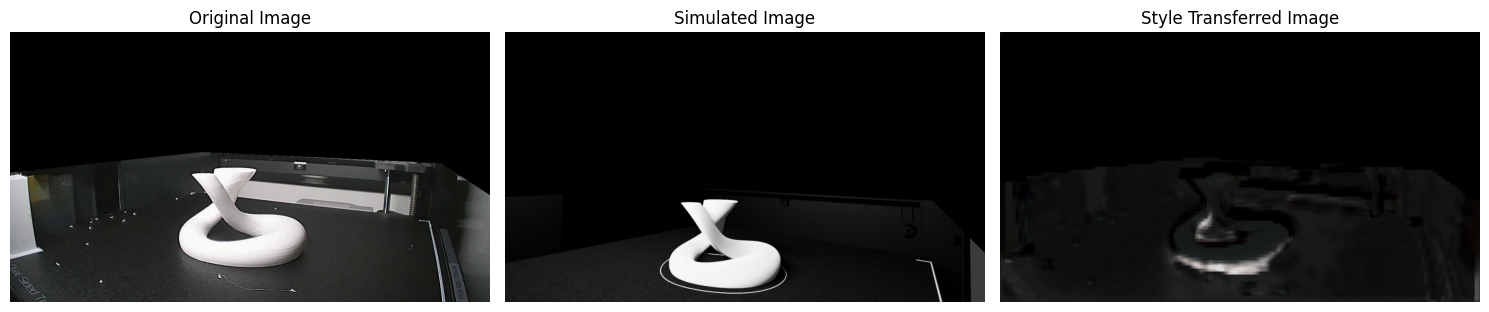

In [15]:
from PIL import Image

def load_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device)

input_image_path = '../../Dataset/AbstractArt/Captures/AbstractArt/Layer_235.jpg'
input_image = load_image(input_image_path)

with torch.no_grad():
    stylized_image = model(input_image)

def tensor_to_image(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

import matplotlib.pyplot as plt
input_image = load_image(input_image_path)
initial_images = model(input_image)

simulated_image = Image.open('../../Dataset/AbstractArt/Renders/AbstractArt/Layer_235.jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(tensor_to_image(input_image))
axes[0].set_title('Original Image')
axes[1].imshow(simulated_image)
axes[1].set_title('Simulated Image')
axes[2].imshow(tensor_to_image(initial_images[0]))
axes[2].set_title('Style Transferred Image')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()